## Intorduction on MobilenetV2 :

MobileNetV2 is a convolutional neural network architecture designed for mobile and embedded vision applications. It was introduced by Google researchers in the paper "MobileNetV2: Inverted Residuals and Linear Bottlenecks" in 2018. MobileNetV2 is an evolution of the original MobileNet architecture, aiming to improve efficiency while maintaining high accuracy in image classification tasks.

## Key features of MobileNetV2:

Depthwise Separable Convolutions: MobileNetV2 heavily utilizes depthwise separable convolutions, which split the standard convolution into two separate operations: depthwise convolution and pointwise convolution. This reduces the computational cost and the number of parameters in the network while preserving representational capacity.

Inverted Residuals with Linear Bottlenecks: MobileNetV2 introduces the concept of inverted residuals with linear bottlenecks, which helps in capturing more complex features using fewer parameters. Inverted residuals use a lightweight bottleneck layer followed by an expansion layer, which expands the number of channels, applies depthwise convolution, and then compresses the channels back with pointwise convolution.

Linear Bottleneck: The linear bottleneck layer helps in reducing the model's capacity when necessary, preventing overfitting and improving efficiency. It consists of a 1x1 convolutional layer followed by batch normalization and a ReLU activation function.

Width Multiplier and Resolution Multiplier: MobileNetV2 introduces two hyperparameters, namely the width multiplier and the resolution multiplier, which allow users to trade-off between latency, accuracy, and model size. The width multiplier controls the number of channels in each layer, while the resolution multiplier scales the input resolution of the network.

Efficiency and Performance: MobileNetV2 achieves a good balance between efficiency and performance, making it suitable for deployment on resource-constrained devices such as mobile phones, IoT devices, and embedded systems. It offers competitive accuracy on image classification benchmarks while being significantly more efficient compared to larger convolutional neural network architectures.

Pre-trained Models: Pre-trained versions of MobileNetV2 are available, which have been trained on large-scale image datasets such as ImageNet. These pre-trained models can be fine-tuned on specific tasks or used as feature extractors for transfer learning.

MobileNetV2 has been widely adopted in various computer vision applications, including image classification, object detection, and semantic segmentation, especially in scenarios where computational resources are limited or real-time performance is required. It provides a lightweight and efficient solution without compromising on accuracy.



In [1]:
# Import the required libarary
from tensorflow.keras import datasets , layers , models
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import save_model,Sequential
import numpy as np
import random

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory (one level up)
current_dir = os.path.dirname(current_dir)

# Get the parent directory (one level up)
parent_dir = os.path.dirname(current_dir)

# Print the parent directory
print("Parent Directory:", parent_dir)

Parent Directory: E:\upgrade_capston_project-main


In [3]:
dataset_dir = parent_dir+"/datasets/raw_dataset/Digital images of defective and good condition tyres" # dataset directory

## DATA PREPROCESSING and FEATURE ENGINEERING

In [4]:
# Define parameters for preprocessing
batch_size = 32
image_size = (160, 160)

In [5]:
#Load the data with the help of the tensorflow keras utils model :
dataset =  tf.keras.utils.image_dataset_from_directory(dataset_dir ,image_size=image_size)                                                                                 
class_name = dataset.class_names

Found 1856 files belonging to 2 classes.


In [6]:
# Data augumenation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                         tf.keras.layers.RandomRotation(0.2),
                                         tf.keras.layers.RandomZoom(0.2)])


In [7]:
# Initiate the object of mobilenet inbuild processess input module
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
# Split the dataset in to train and validation set

In [9]:
val_batches = tf.data.experimental.cardinality(dataset)
print("%d"%val_batches)
validation_dataset = dataset.take(val_batches//4)
train_dataset = dataset.skip(val_batches//4)

58


In [10]:
# SPlit the dataset into test and validation dataset

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print("%d"%val_batches)

test_dataset = validation_dataset.take(val_batches//2)
validation_dataset = validation_dataset.skip(val_batches//2)

14


In [12]:
## Autotune : In TensorFlow, tf.data.AUTOTUNE is a special constant that can be used when configuring input pipelines for better 
## performance. It's particularly useful when dealing with input data pipelines that involve I/O operations. 

In [13]:
AUTOTUNE =  tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset =  validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Feature Engineering

In [14]:
# Define the base model as mobilenetv2

IMG_SHAPE = (160,160)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,include_top=False,weights='imagenet')

In [15]:
# process all the train dataset to basemodel and prepare the batch
image_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
# Setting base_model.trainable = False means that freezing the weights of the pre-trained model (base_model) during training. 
#In other words, the model's weights will not be updated during the training process when this flag is set to False.

In [17]:
base_model.trainable = False

In [18]:
# Model Summary
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# define average pooling layer for feature pooling and dimensionality reduction
global_average_layer =  tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
# Prediction layer with 1 neuron as output of binary classification

In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch =prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Model Building

In [22]:
inputs = tf.keras.layers.Input(shape=(image_size+(3,)))
x = data_augmentation(inputs)
x = preprocess_input(x)         
x = base_model(x,training = False)
x=  global_average_layer(x)
x=  tf.keras.layers.Dropout(0.2)(x)
output=prediction_layer(x)
models = tf.keras.Model(inputs,output)

In [23]:
models.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
              ,metrics=['accuracy'])

In [24]:
# Model Summary

In [25]:
models.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# Validate the accuracy before training
loss0,accuracy0= models.evaluate(validation_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.5560 - loss: 0.8461


In [27]:
# Time to train the model

## Model Training

In [28]:
intial_epochs = 5
history = models.fit(train_dataset,epochs=intial_epochs,validation_data=validation_dataset)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 527s 6s/step - accuracy: 0.5383 - loss: 0.8993 - val_accuracy: 0.5536 - val_loss: 0.7738
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.5771 - loss: 0.7286 - val_accuracy: 0.6562 - val_loss: 0.6095
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 287s 5s/step - accuracy: 0.6538 - loss: 0.6514 - val_accuracy: 0.7009 - val_loss: 0.5651
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - accuracy: 0.6812 - loss: 0.5869 - val_accuracy: 0.7366 - val_loss: 0.5498
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.6879 - loss: 0.5749 - val_accuracy: 0.6786 - val_loss: 0.5376


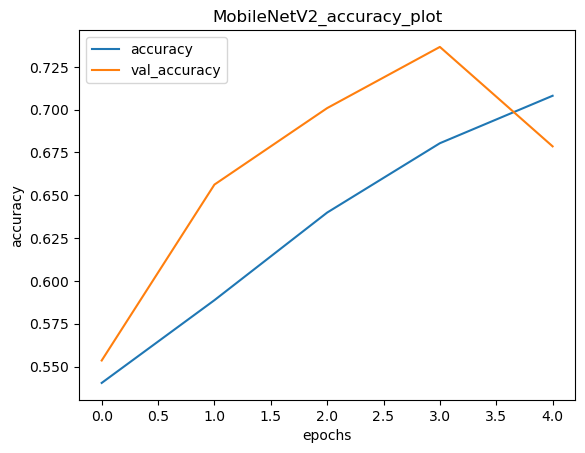

In [29]:
# Plot the accuracy of trained model
plt.plot(history.history['accuracy'],label= 'accuracy')
plt.plot(history.history['val_accuracy'],label= 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title("MobileNetV2_accuracy_plot")
plt.savefig(parent_dir+'\\visuals\\mobilenetv2_accuracy_plot.png')

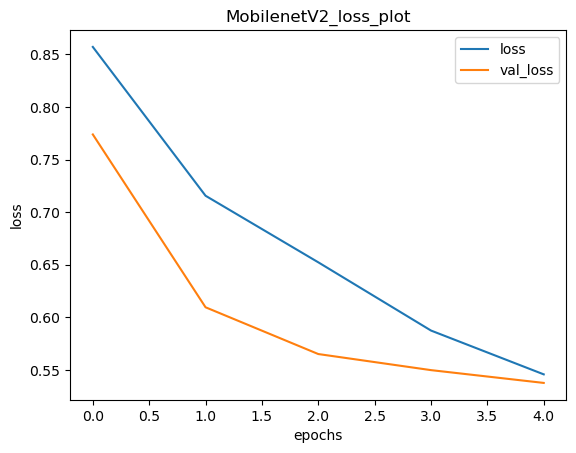

In [30]:
# Plot the loss of trained model
plt.plot(history.history['loss'],label= 'loss')
plt.plot(history.history['val_loss'],label= 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title("MobilenetV2_loss_plot")
plt.savefig(parent_dir+'\\visuals\\mobilenetv2_loss_plot.png')

## Fine Tunning

In [31]:
base_model.trainable = True

In [32]:
print("number of layers in base models" , len(base_model.layers))

number of layers in base models 154


In [33]:
# Base model have 154 layers and we will start fine tune from 101th layer , skipping the 100 layes
fine_tune_at =100

for layers in base_model.layers[:fine_tune_at]:
    layers.trainable = False
    

In [34]:
# Model compilation with RMSprop optimizer this time

In [35]:
models.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
              ,metrics=['accuracy'])

In [36]:
models.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [37]:
# Start model traing on base model 

In [38]:
fine_tune_epoch = 10
totol_epoch =  fine_tune_epoch+intial_epochs

history = models.fit(train_dataset,epochs=totol_epoch,initial_epoch=history.epoch[-1],validation_data=validation_dataset)

Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - accuracy: 0.7069 - loss: 0.6281 - val_accuracy: 0.8125 - val_loss: 0.3840
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 840s 15s/step - accuracy: 0.7801 - loss: 0.4966 - val_accuracy: 0.8348 - val_loss: 0.3572
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - accuracy: 0.8011 - loss: 0.4591 - val_accuracy: 0.8393 - val_loss: 0.3339
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 458s 9s/step - accuracy: 0.8320 - loss: 0.3945 - val_accuracy: 0.8125 - val_loss: 0.3417
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.8435 - loss: 0.3756 - val_accuracy: 0.8482 - val_loss: 0.3007
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 522s 11s/step - accuracy: 0.8623 - loss: 0.3285 - val_accuracy: 0.8036 - val_loss: 0.3524
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 291s 6s/step - accuracy: 0.8407 - loss: 0.3353 - val_accuracy: 0.8304 - val_loss: 0.3091
Epoch 12/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 581s 11s/step - accuracy: 0.8609 - loss: 0.3331 - val_accuracy: 0.87

In [39]:
# Since the accuracy is not upto the mark lets increase the epoch to 10 more cycles

In [40]:
fine_tune_epoch = 10
intial_epochs =15
totol_epoch =  fine_tune_epoch+intial_epochs

history = models.fit(train_dataset,epochs=totol_epoch,initial_epoch=history.epoch[-1],validation_data=validation_dataset)

Epoch 15/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 506s 10s/step - accuracy: 0.8952 - loss: 0.2543 - val_accuracy: 0.8214 - val_loss: 0.2892
Epoch 16/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.8777 - loss: 0.2799 - val_accuracy: 0.8750 - val_loss: 0.2260
Epoch 17/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - accuracy: 0.8766 - loss: 0.2744 - val_accuracy: 0.8393 - val_loss: 0.2620
Epoch 18/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step - accuracy: 0.8932 - loss: 0.2756 - val_accuracy: 0.8393 - val_loss: 0.3381
Epoch 19/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.8823 - loss: 0.2611 - val_accuracy: 0.8438 - val_loss: 0.2242
Epoch 20/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - accuracy: 0.9237 - loss: 0.2117 - val_accuracy: 0.8884 - val_loss: 0.1983
Epoch 21/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.9046 - loss: 0.2293 - val_accuracy: 0.8571 - val_loss: 0.2538
Epoch 22/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.8946 - loss: 0.2457 - val_accuracy: 0

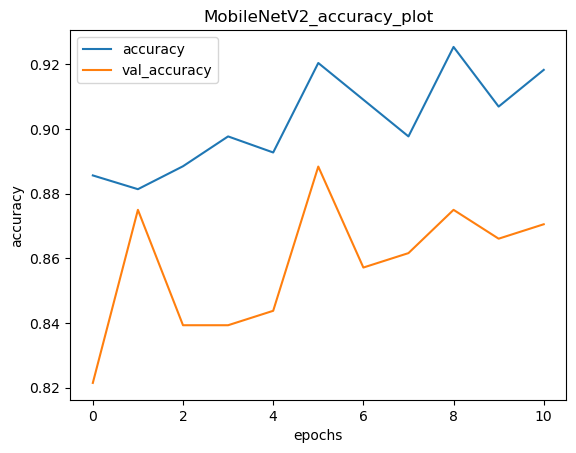

In [41]:
# Plot the accuracy of trained model
plt.plot(history.history['accuracy'],label= 'accuracy')
plt.plot(history.history['val_accuracy'],label= 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title("MobileNetV2_accuracy_plot")
plt.savefig(parent_dir+'\\visuals\\mobilenetv2_finetune_accuracy_plot.png')

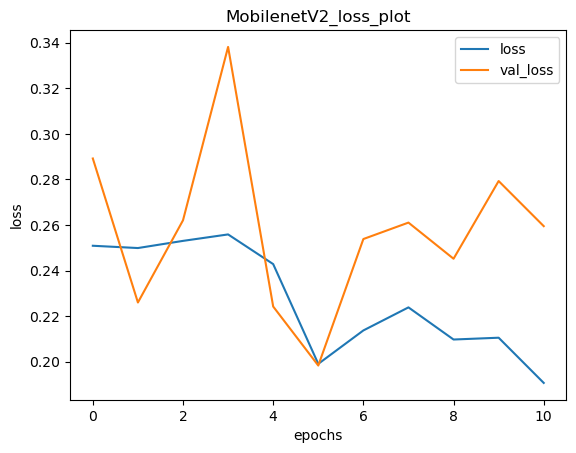

In [42]:
# Plot the loss of trained model
plt.plot(history.history['loss'],label= 'loss')
plt.plot(history.history['val_loss'],label= 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title("MobilenetV2_loss_plot")
plt.savefig(parent_dir+'\\visuals\\mobilenetv2_finetune_loss_plot.png')

In [43]:
# Save the data in form of tensorflow object
tf.data.Dataset.save(test_dataset, parent_dir+'/datasets/processed_dataset/mobilenetV2_test_datasets.tfrecord')
tf.data.Dataset.save(train_dataset, parent_dir+'/datasets/processed_dataset/mobilenetV2_train_datasets.tfrecord')
tf.data.Dataset.save(validation_dataset, parent_dir+'/datasets/processed_dataset/mobilenetV2_validation_datasets.tfrecord')

In [44]:
# Save the model
save_model(models , parent_dir+"/models/mobilenet_model.keras")